In [1]:
import tensorflow as tf
#import tensorflow_addons as tsa
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
import tensorflow_addons as tfa
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from datetime import datetime
from IPython import display
import os

In [2]:
UNSCALED_HEIGHT = 968
UNSCALED_WIDTH = 1296 # TODO: These should be computed, not added manually
IMG_HEIGHT = 256
IMG_WIDTH = 256
INPUT_FOLDER_NAME = 'uv'
COLOR_FOLDER_NAME = 'color'#'color_rend'
BATCH_SIZE = 1 # TODO: Set larger
EPOCHS = 200
UV_CHANNELS = 2 # TODO: Make sure this is in all appropriate places

In [3]:
# Check how many GPUs are available
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
# Set up tensorboard
%load_ext tensorboard

In [5]:
def generate_temporal_train_test_split(temporal_file_pairs, skip):
    num_pairs = len(temporal_file_pairs)
    
    # Separate train and test by selecting evenly spaced samples throughout the dataset
    train_filenames = [temporal_file_pairs[i] for i in range(num_pairs) if (i % skip) != 0]
    test_filenames = [temporal_file_pairs[i] for i in range(num_pairs) if (i % skip) == 0]
    
    return train_filenames, test_filenames

In [6]:
def load_train_test_files(skip):
    # Import file names
    # TODO: Check that every input file has an associated color file
    input_filenames = tf.io.gfile.glob('data/' + INPUT_FOLDER_NAME + '/*')
    color_filenames = tf.io.gfile.glob('data/' + COLOR_FOLDER_NAME + '/*')

    # Sort by file name. Assumed to be numbered temporally.
    input_filenames.sort()
    color_filenames.sort()

    # TODO: Set number used in top of file
    NUM_INPUTS = 1000
    input_filenames[0:NUM_INPUTS]
    color_filenames[0:NUM_INPUTS]
    
    # Create input/label pairs
    # TODO: Use entire dataset
    input_color_filenames = list(zip(input_filenames, color_filenames))

    # Separate train and test sets
    train_filenames, test_filenames = generate_temporal_train_test_split(input_color_filenames, skip)
    
    print('First train filenames')
    for f in train_filenames:#[0:5]:
        print(f)

    print('First test filenames')
    for f in test_filenames:#[0:5]:
        print(f)
        
    train_filenames = tf.convert_to_tensor(train_filenames)
    test_filenames = tf.convert_to_tensor(test_filenames)
    
    return train_filenames, test_filenames


In [7]:
def load_jpg(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)
    image = tf.cast(image, tf.float32)

    return image

In [8]:
def load_raw(raw_file):
    raw = tf.io.read_file(raw_file)
    raw = tf.io.decode_raw(raw, tf.float32)
    raw = tf.reshape(raw, (UNSCALED_HEIGHT, UNSCALED_WIDTH, UV_CHANNELS))
    raw = tf.reverse(raw, axis=[0]) # OpenGL flips image vertically
    
    return raw

In [9]:
# normalizing the images to [-1, 1]
def normalize(image):
    image = (image / 127.5) - 1

    return image

In [10]:
def resize(image, height, width):
    image = tf.image.resize(image, [height, width],
                            method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return image

In [11]:
def random_crop(input_image, color_image):
    stacked_image = tf.stack([input_image, color_image], axis=0)
    cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image[0], cropped_image[1]

In [12]:
@tf.function()
def random_jitter(input_image, color_image):
    # resizing to 286 x 286 x 3
    input_image, color_image = resize(input_image, color_image, 286, 286)

    # randomly cropping to 256 x 256 x 3
    input_image, color_image = random_crop(input_image, color_image)

    if tf.random.uniform(()) > 0.5:
        # random mirroring
        input_image = tf.image.flip_left_right(input_image)
        color_image = tf.image.flip_left_right(color_image)

    return input_image, color_image

In [13]:
def load_image_train(file_tup):#, color_file):
    # TODO: Load tuple as function params
    input_file = file_tup[0]
    color_file = file_tup[1]
    input_image = load_raw(input_file)
    color_image = load_jpg(color_file)
    
    input_image = resize(input_image, IMG_HEIGHT, IMG_WIDTH) 
    color_image = resize(color_image, IMG_HEIGHT, IMG_WIDTH) 
    # TODO: Add augmentation of input data
    #input_image, color_image = random_jitter(input_image, color_image)
    # TODO: Potentially remove input normalization once I'm importing correct uv vales
    #input_image = normalize(input_image) # TODO: Don't normalize since values are indices
    color_image = normalize(color_image)
    
    return input_image, color_image

In [14]:
def load_image_test(file_tup):
    # TODO: Load tuple as function params
    input_file = file_tup[0]
    color_file = file_tup[1]
    input_image = load_raw(input_file)
    color_image = load_jpg(color_file)
 
    input_image = resize(input_image, IMG_HEIGHT, IMG_WIDTH) 
    color_image = resize(color_image, IMG_HEIGHT, IMG_WIDTH) 
    #input_image = normalize(input_image)  # TODO: Don't normalize since values are indices
    color_image = normalize(color_image)

    return input_image, color_image

In [15]:
# Load filenames of train and test data
train_filenames, test_filenames = load_train_test_files(skip=6)

# Prepare train dataset
train_dataset = tf.data.Dataset.from_tensor_slices(train_filenames)
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(len(train_filenames))
train_dataset = train_dataset.batch(BATCH_SIZE)

# Prepare test dataset
test_dataset = tf.data.Dataset.from_tensor_slices(test_filenames)
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

First train filenames
('data/uv/0000001', 'data/color/0000001.jpg')
('data/uv/0000002', 'data/color/0000002.jpg')
('data/uv/0000003', 'data/color/0000003.jpg')
('data/uv/0000004', 'data/color/0000004.jpg')
('data/uv/0000005', 'data/color/0000005.jpg')
('data/uv/0000007', 'data/color/0000007.jpg')
('data/uv/0000008', 'data/color/0000008.jpg')
('data/uv/0000009', 'data/color/0000009.jpg')
('data/uv/0000010', 'data/color/0000010.jpg')
('data/uv/0000011', 'data/color/0000011.jpg')
('data/uv/0000013', 'data/color/0000013.jpg')
('data/uv/0000014', 'data/color/0000014.jpg')
('data/uv/0000015', 'data/color/0000015.jpg')
('data/uv/0000016', 'data/color/0000016.jpg')
('data/uv/0000017', 'data/color/0000017.jpg')
('data/uv/0000019', 'data/color/0000019.jpg')
('data/uv/0000020', 'data/color/0000020.jpg')
('data/uv/0000021', 'data/color/0000021.jpg')
('data/uv/0000022', 'data/color/0000022.jpg')
('data/uv/0000023', 'data/color/0000023.jpg')
('data/uv/0000025', 'data/color/0000025.jpg')
('data/uv/00

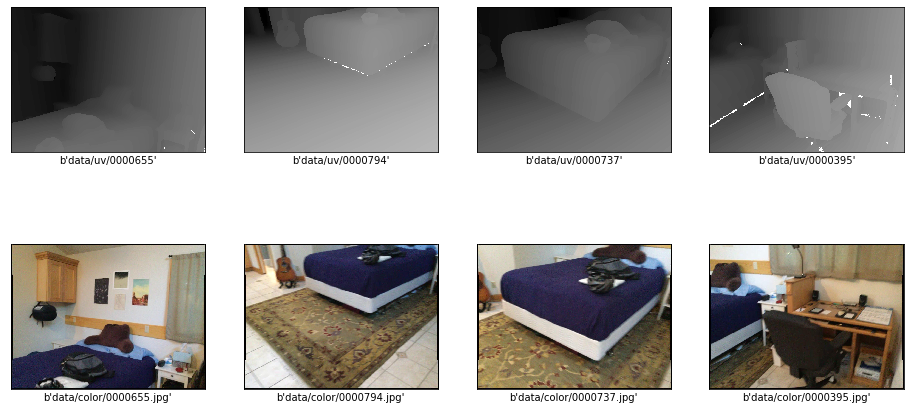

In [16]:
# Display sample on Tensorboard
#file_path = next(iter(train_dataset))
#uv_img, color_img = parse_image(file_path)

#def show(uv_img, color_img, file_path):
#  plt.figure()
#  plt.imshow(image)
#  plt.title(file_path.numpy().decode('utf-8'))
#  plt.axis('off')

#show(uv_img, color_img, file_path)



# Display sample of dataset
plt.figure(figsize=(16,8))
for i in range(4):
    r = np.random.randint(len(train_filenames))
    plt.subplot(2,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = load_raw(train_filenames[r,0]).numpy()
    #if i == 0:
    #    print(img[115:120, 115:120])
    plt.imshow(img[:,:,0], cmap=plt.cm.binary)
    plt.xlabel(train_filenames[r,0].numpy())
    plt.subplot(2,4,i+1+4)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = plt.imread(train_filenames[r,1].numpy(), format='jpeg')
    #if i == 1:
    #    print(img[115:120, 115:120])
    plt.imshow(img, cmap=plt.cm.binary)
    plt.xlabel(train_filenames[r,1].numpy())
plt.show()

In [17]:
# https://www.tensorflow.org/guide/keras/custom_layers_and_models
class NeuralTexture(Layer):

    def __init__(self, height, width, channels, **kwargs):
        super(NeuralTexture, self).__init__(**kwargs)
        self.height = height
        self.width = width
        self.size = tf.constant([self.height, self.width], dtype=tf.float32)
        self.channels = channels
        # TODO: Set mean and stddev of initializer
        w_init = tf.random_normal_initializer()
        # TODO: WARNING: Added size 1 to batch dimension but should be something else like '?' or None?
        self.w = tf.Variable(initial_value=w_init(shape=(1, height, width, channels),
                                                  dtype='float32'),
                             trainable=True)
        #self.w = tf.expand_dims(self.w, 0)
        
        # TODO: Should there be a bias as well?

    def call(self, inputs):
        # Remove the third channel (TODO: if it exists anymore?)
        inputs = inputs[:,:,:,0:2] 
        # Scale indices to size of neural texture with the power of broadcasting
        inputs = tf.multiply(inputs, self.size)
        batch, height, width, channels = inputs.shape
        N = height * width
        inputs = tf.reshape(inputs, shape=[-1, N, channels])
        sampled_tex = tfa.image.interpolate_bilinear(self.w, inputs, indexing='xy', name="sampled_texture")
        sampled_tex = tf.reshape(sampled_tex, shape=[-1, height, width, channels])
        return sampled_tex#inputs#tf.matmul(inputs, self.w)
    
    def get_config(self):
        return {'height': self.height, 'width': self.width, 'channels': self.channels}

In [18]:
class DeferredNeuralRenderer(Layer):
    def __init__(self, **kwargs):
        super(DeferredNeuralRenderer, self).__init__(**kwargs)
    
    def build(self, input_shape):
        print(input_shape)
        lr_alpha = 0.2
        # TODO: Should this be defined indivisually for all layers?
        leakyrelu = tf.keras.layers.LeakyReLU(alpha=lr_alpha)
        
        # TODO: Does conv1 not need any information from input_shape? For example, the number of channels
        self.conv1 = Conv2D(64, 4, strides=(2, 2), activation = leakyrelu, padding = 'same', kernel_initializer = 'he_normal')
        self.norm1 = tfa.layers.InstanceNormalization()
        self.conv2 = Conv2D(128, 4, strides=(2, 2), activation = leakyrelu, padding = 'same', kernel_initializer = 'he_normal')
        self.norm2 = tfa.layers.InstanceNormalization()
        self.conv3 = Conv2D(256, 4, strides=(2, 2), activation = leakyrelu, padding = 'same', kernel_initializer = 'he_normal')
        self.norm3 = tfa.layers.InstanceNormalization()
        self.conv4 = Conv2D(512, 4, strides=(2, 2), activation = leakyrelu, padding = 'same', kernel_initializer = 'he_normal')
        self.norm4 = tfa.layers.InstanceNormalization()
        self.conv5 = Conv2D(512, 4, strides=(2, 2), activation = leakyrelu, padding = 'same', kernel_initializer = 'he_normal')
        self.norm5 = tfa.layers.InstanceNormalization()
        
        self.conv6 = Conv2DTranspose(512, 4, strides=(2, 2), activation = leakyrelu, padding = 'same', kernel_initializer = 'he_normal')
        self.norm6 = tfa.layers.InstanceNormalization()
        self.conv7 = Conv2DTranspose(512, 4, strides=(2, 2), activation = leakyrelu, padding = 'same', kernel_initializer = 'he_normal')
        self.norm7 = tfa.layers.InstanceNormalization()
        self.conv8 = Conv2DTranspose(256, 4, strides=(2, 2), activation = leakyrelu, padding = 'same', kernel_initializer = 'he_normal')
        self.norm8 = tfa.layers.InstanceNormalization()
        self.conv9 = Conv2DTranspose(128, 4, strides=(2, 2), activation = leakyrelu, padding = 'same', kernel_initializer = 'he_normal')
        self.norm9 = tfa.layers.InstanceNormalization()
        self.conv10 = Conv2DTranspose(3, 4, strides=(2, 2), activation = 'tanh', padding = 'same', kernel_initializer = 'glorot_normal')
        #conv10 = Conv2DTranspose(64, 4, stride=(2, 2), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge10)
        #conv10 = Conv2D(3, 1, activation = 'tanh', padding = 'same', kernel_initializer = 'glorot_normal')(conv10)
    
    def call(self, inputs):
        # Encoder Layer 1
        c1 = self.conv1(inputs)
        n1 = self.norm1(c1)
        # Encoder Layer 2
        c2 = self.conv2(n1)
        n2 = self.norm2(c2)
        # Encoder Layer 3
        c3 = self.conv3(c2)
        n3 = self.norm3(c3)
        # Encoder Layer 4
        c4 = self.conv4(c3)
        n4 = self.norm4(c4)
        # Encoder Layer 5
        c5 = self.conv5(c4)
        n5 = self.norm5(c5)

        # Decoder Layer 5
        c6 = self.conv6(c5)
        n6 = self.norm6(c6)
        # Decoder Layer 4
        merge7 = concatenate([n4, n6], axis = 3)
        c7 = self.conv7(merge7)
        n7 = self.norm7(c7)
        # Decoder Layer 3
        merge8 = concatenate([n3, n7], axis = 3)
        c8 = self.conv8(merge8)
        n8 = self.norm8(c8)
        # Decoder Layer 2
        merge9 = concatenate([n2, n8], axis = 3)
        c9 = self.conv9(merge9)
        n9 = self.norm9(c9)
        # Decoder Layer 1
        merge10 = concatenate([n1, n9], axis = 3)
        c10 = self.conv10(merge10)

        return c10


In [19]:
#num_filters = 8
#filter_size = 8

#model = Sequential([
#  Conv2D(num_filters, filter_size, padding="same", strides=(2, 2), activation='relu'),
#  Conv2DTranspose(3, filter_size, padding="same", strides=(2, 2), activation = 'tanh', kernel_initializer = 'glorot_normal')
#])

In [20]:
class RenderNet(Model):
    def __init__(self):
        super(RenderNet, self).__init__()
        # TODO: Make size larger and scale UV coords appropriately
        self.neural_texture = NeuralTexture(256, 256, 16)#1024, 1024, 16) # TODO: Change to 512 or 1024
        self.neural_renderer = DeferredNeuralRenderer()

    def call(self, inputs, training=False):
        # TODO: How to augment network for training=True
        x = self.neural_texture(inputs)
        x = self.neural_renderer(x)
        return x

In [21]:
# Loss function
# Not from logits (non-normalized network output) because the last layer has a tanh activations
#loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=False)
loss_object = tf.keras.losses.MeanAbsoluteError()

In [22]:
# Optimizer
optimizer = tf.keras.optimizers.Adam(lr = 1e-3)#1e-3)

In [23]:
model = RenderNet()

#model.compile(optimizer = optimizer, loss = loss_object, metrics = ['accuracy'])
#model.build((None, IMG_HEIGHT, IMG_WIDTH, 3))
#model.summary()

In [24]:
# Trainable network components
#model = neural_renderer_model_ct(optimizer, loss_object)

In [25]:
# https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
# https://www.tensorflow.org/guide/keras/train_and_evaluate
#log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# Creates a file writer for the log directory.
#file_writer = tf.summary.create_file_writer(log_dir)
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
#model.fit(train_dataset, epochs=EPOCHS, validation_data=test_dataset, callbacks=[tensorboard_callback])

In [26]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15,15))

    # Cut off one dimension
    #print(test_input.shape)
    test_input = test_input[:,:,:,0]

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

(8, 256, 256, 2)


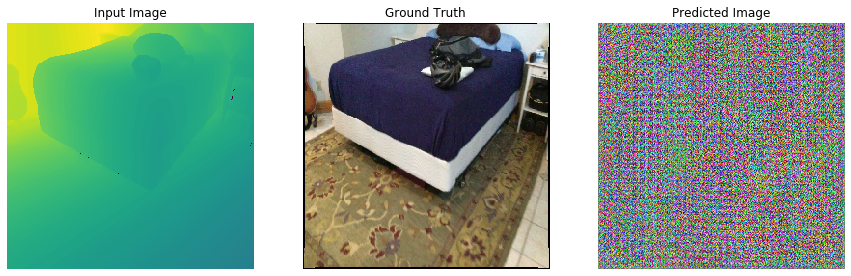

In [27]:
for example_input, example_target in train_dataset.take(1):
    generate_images(model, example_input, example_target)

In [28]:
# Metrics
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.BinaryAccuracy(name='test_accuracy')

In [29]:
@tf.function
def train_step(uv_maps, color_images):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = model(uv_maps, training=True)
        loss = loss_object(color_images, predictions)
    # TODO: Add if warning that "Gradients do not exist for variables"
    # See: https://www.reddit.com/r/tensorflow/comments/bcl5ke/help_with_custom_training_loops_in_tensorflow_20/
    #gradients = tape.gradient(loss, model.trainable_variables)
    #gradients = [grad if grad is not None else tf.zeros_like(var)
    #             for var, grad in zip(model.trainable_variables, grads)]
    
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(color_images, predictions)

In [30]:
@tf.function
def test_step(uv_maps, color_images):
    # training=False is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(uv_maps, training=False)
    t_loss = loss_object(color_images, predictions)

    test_loss(t_loss)
    test_accuracy(color_images, predictions)

In [31]:
# Log files for tensorboard
current_time = datetime.now().strftime("%Y%m%d-%H%M%S")

train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
test_log_dir = 'logs/gradient_tape/' + current_time + '/test'
input_image_log_dir = "logs/images/" + current_time + '/input'
ground_truth_image_log_dir = "logs/images/" + current_time + '/ground_truth'
predicted_image_log_dir = "logs/images/" + current_time + '/predicted'

train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)
input_image_writer = tf.summary.create_file_writer(input_image_log_dir)
ground_truth_image_writer = tf.summary.create_file_writer(ground_truth_image_log_dir)
predicted_image_writer = tf.summary.create_file_writer(predicted_image_log_dir)

In [32]:
# Train loop
def disp_image(img, name, epoch):
    # Sets up a timestamped log directory.
    img_log = logdir + "-" + name
    # Creates a file writer for the log directory.
    file_writer = tf.summary.create_file_writer(img_log)

    #print(img.shape)
    #print(img[0,100:105,100:105,1])
    
    # Using the file writer, log the reshaped image.
    with file_writer.as_default():
        tf.summary.image(name, img, step=epoch)
        
for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    # TESTING only
    #display.clear_output(wait=True)
    #for example_input, example_target in test_dataset.take(1):
    #    generate_images(model, example_input, example_target)

    # Write input, ground truth and prediction to tensorboard
    for test_input, test_target in test_dataset.take(1):
        test_pred = model(test_input, training=True) # TODO: training=true necessary?
        with input_image_writer.as_default():
            tf.summary.image('UV Map', test_input, step=epoch)
        with ground_truth_image_writer.as_default():
            tf.summary.image('Ground Truth', test_target, step=epoch)
        with predicted_image_writer.as_default():
            tf.summary.image('Predicted', test_pred, step=epoch)
    
    for uv_maps, color_images in train_dataset:
        train_step(uv_maps, color_images)
    with train_summary_writer.as_default():
        tf.summary.scalar('loss', train_loss.result(), step=epoch)
        tf.summary.scalar('accuracy', train_accuracy.result(), step=epoch)

    for test_uv_maps, test_color_images in test_dataset:
        test_step(test_uv_maps, test_color_images)
    with test_summary_writer.as_default():
        tf.summary.scalar('loss', test_loss.result(), step=epoch)
        tf.summary.scalar('accuracy', test_accuracy.result(), step=epoch)

    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print(template.format(epoch + 1,
                        train_loss.result(),
                        train_accuracy.result() * 100,
                        test_loss.result(),
                        test_accuracy.result() * 100))

Epoch 1, Loss: 0.39256012439727783, Accuracy: 0.0031421480234712362, Test Loss: 0.35633474588394165, Test Accuracy: 0.01406308263540268
Epoch 2, Loss: 0.32913097739219666, Accuracy: 0.013822720386087894, Test Loss: 0.3070095181465149, Test Accuracy: 0.014756664633750916
Epoch 3, Loss: 0.2914690375328064, Accuracy: 0.017356369644403458, Test Loss: 0.28190919756889343, Test Accuracy: 0.02063332125544548
Epoch 4, Loss: 0.2716611325740814, Accuracy: 0.01902930438518524, Test Loss: 0.2658137083053589, Test Accuracy: 0.022686250507831573
Epoch 5, Loss: 0.2593773305416107, Accuracy: 0.02060830593109131, Test Loss: 0.2564528286457062, Test Accuracy: 0.020793350413441658
Epoch 6, Loss: 0.24814221262931824, Accuracy: 0.021634714677929878, Test Loss: 0.2466544210910797, Test Accuracy: 0.02208261750638485
Epoch 7, Loss: 0.24057215452194214, Accuracy: 0.021871155127882957, Test Loss: 0.23871859908103943, Test Accuracy: 0.022225309163331985
Epoch 8, Loss: 0.2317349910736084, Accuracy: 0.022435868158

Epoch 59, Loss: 0.11884478479623795, Accuracy: 0.0263613760471344, Test Loss: 0.13875137269496918, Test Accuracy: 0.026459403336048126
Epoch 60, Loss: 0.11831168830394745, Accuracy: 0.026348507031798363, Test Loss: 0.13933216035366058, Test Accuracy: 0.02644387073814869
Epoch 61, Loss: 0.11670735478401184, Accuracy: 0.026358608156442642, Test Loss: 0.13870035111904144, Test Accuracy: 0.027012821286916733
Epoch 62, Loss: 0.11657197773456573, Accuracy: 0.02626764215528965, Test Loss: 0.14046473801136017, Test Accuracy: 0.027074234560132027
Epoch 63, Loss: 0.11625339090824127, Accuracy: 0.02639399655163288, Test Loss: 0.13555282354354858, Test Accuracy: 0.026513228192925453
Epoch 64, Loss: 0.1145690307021141, Accuracy: 0.026361452415585518, Test Loss: 0.13693951070308685, Test Accuracy: 0.026650862768292427
Epoch 65, Loss: 0.11437471956014633, Accuracy: 0.026471959426999092, Test Loss: 0.13720747828483582, Test Accuracy: 0.027089767158031464
Epoch 66, Loss: 0.11352062225341797, Accuracy: 

Epoch 120, Loss: 0.08765511959791183, Accuracy: 0.02759181335568428, Test Loss: 0.11988916993141174, Test Accuracy: 0.028378313407301903
Epoch 121, Loss: 0.08795427531003952, Accuracy: 0.027606699615716934, Test Loss: 0.11811986565589905, Test Accuracy: 0.027644991874694824
Epoch 122, Loss: 0.0874231681227684, Accuracy: 0.02755829505622387, Test Loss: 0.12002959847450256, Test Accuracy: 0.0281850453466177
Epoch 123, Loss: 0.08714208006858826, Accuracy: 0.027682999148964882, Test Loss: 0.11862314492464066, Test Accuracy: 0.027701348066329956
Epoch 124, Loss: 0.08634140342473984, Accuracy: 0.02765415608882904, Test Loss: 0.12022145092487335, Test Accuracy: 0.028200944885611534
Epoch 125, Loss: 0.0872744470834732, Accuracy: 0.02766781859099865, Test Loss: 0.11913061141967773, Test Accuracy: 0.028340382501482964
Epoch 126, Loss: 0.08674934506416321, Accuracy: 0.027709582820534706, Test Loss: 0.11828600615262985, Test Accuracy: 0.028159402310848236
Epoch 127, Loss: 0.08576103299856186, Accu

Epoch 180, Loss: 0.07535738497972488, Accuracy: 0.028260501101613045, Test Loss: 0.11418033391237259, Test Accuracy: 0.027708573266863823
Epoch 181, Loss: 0.07532050460577011, Accuracy: 0.028208985924720764, Test Loss: 0.1120561808347702, Test Accuracy: 0.027907976880669594
Epoch 182, Loss: 0.0740242749452591, Accuracy: 0.028262903913855553, Test Loss: 0.11268358677625656, Test Accuracy: 0.0282699353992939
Epoch 183, Loss: 0.07472352683544159, Accuracy: 0.028307368978857994, Test Loss: 0.11168146878480911, Test Accuracy: 0.028316175565123558
Epoch 184, Loss: 0.07477904111146927, Accuracy: 0.028265956789255142, Test Loss: 0.11232182383537292, Test Accuracy: 0.028764113783836365
Epoch 185, Loss: 0.07419120520353317, Accuracy: 0.028324075043201447, Test Loss: 0.11122607439756393, Test Accuracy: 0.028090042993426323
Epoch 186, Loss: 0.07412467151880264, Accuracy: 0.0283504631370306, Test Loss: 0.11126331984996796, Test Accuracy: 0.028384456411004066
Epoch 187, Loss: 0.07397983223199844, Ac

In [ ]:
print('----Train----')
for example_input, example_target in list(train_dataset.take(100))[0:100:20]:
    generate_images(model, example_input, example_target)
print('----Test----')
for example_input, example_target in list(test_dataset.take(100))[0:100:20]:
    generate_images(model, example_input, example_target)

----Train----


In [38]:
model.save_weights('./checkpoints/20200605-031915_checkpoint')